# Analyzing Banking Transactions


## Objective of the project

This is a personal project to get insights related to my personal expenses and how they have been influence by COVID. In this notebook I analyze bank statements from my everyday banking account and my two credit cards. In this notebook I am practicing my skills in:
* Pandas for working with files and datasets
* Seaborn and Ploty to plot the different figures
* Natural Language Processing (NLP) for the transactions description analysis (nltk)
* Scikit Learn to classify my bank transactions

### Challenges
* How to classify properly the transactions?
* I have one banking account and two credit cards in two different banks. Money from the banking account is used to pay the credit cards. How to combine the information?



### Considerations
- Data is available from Nov 2018. I will use data between Dec. 1st 2018 and Sep. 30, 2020
- Transactions are made in Canadian dollars (CAD)
- If you would like to do a similar analysis, your personal bank has the option to export your transactions to a CSV file.

## Initial setup
Import the needed packages: pandas, numpy and seaborn, matplotlib and plotly

In [45]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import datetime
import re   # Regular expressions

import nltk   # natural language tool kit
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

%matplotlib inline
#import cufflinks as cf
print("Pandas version: ", pd.__version__)

Pandas version:  1.1.2


## Pre-processing

For the pre-processing of the data, the CSV files generated by the two different banks are read. Then, null values corresponding to "Transaction Type" are filled with "NA" and the null values corresponding to credit card payments are dropped. Finally, some features are added: year, month, day, week of year, weekday.

### Read Dataset

In [2]:
# Read the dataset for Banking account
df_banking = pd.read_csv('banking.csv', header=None, usecols=[0, 1, 3, 4], names = ['Transaction Date', 'Quantity', 'Transaction description', 'Transaction Type'], parse_dates=['Transaction Date'])
df_banking = df_banking.set_index('Transaction Date')
print(f'Shape of dataframe: {df_banking.shape}')
df_banking = df_banking.sort_index()
df_banking.head()

Shape of dataframe: (704, 3)


,Quantity,Transaction description,Transaction Type
Transaction Date,,,
2018-11-01,-550.00,WITHDRAWAL,MB-EMAIL MONEY TRF
2018-11-01,45.00,Miscellaneous Payment,PAYPAL
2018-11-01,-0.00,Service Charge,MB-FREE EMAIL MONEY TRF
2018-11-01,-50.00,Customer Transfer Dr.,MB-TRANSFER
2018-11-01,-37.91,Customer Transfer Dr.,MB-TRANSFER


In [3]:
# Read the dataset for credit card bank 1
df_creditcard_bank01 = pd.read_csv('bank01_creditcard.csv', header=None, names = ['Transaction Date', 'Transaction description', 'Quantity'],  parse_dates=['Transaction Date'])
df_creditcard_bank01 = df_creditcard_bank01.set_index('Transaction Date')
print(f'Shape of dataframe: {df_creditcard_bank01.shape}')
df_creditcard_bank01 = df_creditcard_bank01.sort_index()
df_creditcard_bank01.head()

Shape of dataframe: (559, 2)


,Transaction description,Quantity
Transaction Date,,
2018-11-02,ADOBE *PHOTOGPHY PLAN 8008336687 CA AMT ...,-15.18
2018-11-02,MB-CREDIT CARD/LOC PAY. FROM - 55376...,15.24
2018-11-03,MB-CREDIT CARD/LOC PAY. FROM - 55376...,57.80
2018-11-03,KOODO MOBILE PAC EDMONTON AB,-57.80
2018-11-04,AMZN Mktp CA*M84F08MK2 WWW.AMAZON.CAON,-38.98


In [4]:
# Read the dataset for credit card bank 2 and join them (In this case the transactions available are only last 25 months and you can download 12 months at a time)
df_creditcard_bank02a = pd.read_csv('bank02_creditcard_01.csv', usecols=[0, 3, 4, 5, 6], parse_dates=['Transaction Date'])
df_creditcard_bank02b = pd.read_csv('bank02_creditcard_02.csv', usecols=[0, 3, 4, 5, 6], parse_dates=['Transaction Date'])
df_creditcard_bank02 = pd.concat([df_creditcard_bank02a, df_creditcard_bank02b ])
df_creditcard_bank02 = df_creditcard_bank02.set_index('Transaction Date')

# Debit column should be negative
df_creditcard_bank02['Debit'] = -df_creditcard_bank02['Debit']
# Null values should be zero in Debit and credit columns. A new column 'Quantity' is created from Debit and Credit
df_creditcard_bank02.loc[df_creditcard_bank02['Debit'].isnull(), 'Debit'] = 0
df_creditcard_bank02.loc[df_creditcard_bank02['Credit'].isnull(), 'Credit'] = 0
df_creditcard_bank02['Quantity'] = df_creditcard_bank02['Debit'] + df_creditcard_bank02['Credit']

print(f'Shape of dataframe: {df_creditcard_bank02.shape}')
 
# df_creditcard_bank02 = df_creditcard_bank02.rename(columns={'Debit': 'Quantity'})
df_creditcard_bank02 = df_creditcard_bank02.sort_index()
df_creditcard_bank02.head()

Shape of dataframe: (370, 5)


,Description,Category,Debit,Credit,Quantity
Transaction Date,,,,,
2018-10-27,COSTCO WHOLESALE W530,Merchandise,-317.69,0.00,-317.69
2018-10-30,PAYMENT,Payment/Credit,0.00,317.69,317.69
2018-10-31,PAYMENT,Payment/Credit,0.00,120.00,120.00
2018-11-15,INTEREST CHARGES,Fee/Interest Charge,-12.14,0.00,-12.14
2018-11-23,LACSA 1133M5A,Airfare,-1174.44,0.00,-1174.44


### Check if there are null values

In [5]:
df_banking.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 704 entries, 2018-11-01 to 2020-10-13
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Quantity                 704 non-null    float64
 1   Transaction description  704 non-null    object 
 2   Transaction Type         678 non-null    object 
dtypes: float64(1), object(2)
memory usage: 22.0+ KB


In [6]:
# Fill NULL transaction type with "NA"
df_banking['Transaction Type'] = df_banking['Transaction Type'].fillna("NA")
df_banking[df_banking['Transaction Type'].isnull()]

,Quantity,Transaction description,Transaction Type
Transaction Date,,,


In [7]:
df_creditcard_bank01.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 559 entries, 2018-11-02 to 2020-10-14
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Transaction description  559 non-null    object 
 1   Quantity                 559 non-null    float64
dtypes: float64(1), object(1)
memory usage: 13.1+ KB


In [8]:
df_creditcard_bank02.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 370 entries, 2018-10-27 to 2020-09-21
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Description  370 non-null    object 
 1   Category     370 non-null    object 
 2   Debit        370 non-null    float64
 3   Credit       370 non-null    float64
 4   Quantity     370 non-null    float64
dtypes: float64(3), object(2)
memory usage: 17.3+ KB


In [9]:
# Null values correspond to Payments of the credit card and are going to be dropped
df_creditcard_bank02 = df_creditcard_bank02.dropna()
df_creditcard_bank02[df_creditcard_bank02['Quantity'].isnull()].shape

(0, 5)

In [10]:
df_banking.dtypes

Quantity                   float64
Transaction description     object
Transaction Type            object
dtype: object

### Addition of features for year, month , day

In [11]:
df_banking['Year'] = df_banking.index.year
df_banking['Month'] = df_banking.index.month
df_banking['Day'] = df_banking.index.day
df_banking['Week'] = df_banking.index.isocalendar().week  
df_banking['Weekday'] = df_banking.index.weekday

df_creditcard_bank01['Year'] = df_creditcard_bank01.index.year
df_creditcard_bank01['Month'] = df_creditcard_bank01.index.month
df_creditcard_bank01['Day'] = df_creditcard_bank01.index.day
df_creditcard_bank01['Week'] = df_creditcard_bank01.index.isocalendar().week  
df_creditcard_bank01['Weekday'] = df_creditcard_bank01.index.weekday

df_creditcard_bank02['Year'] = df_creditcard_bank02.index.year
df_creditcard_bank02['Month'] = df_creditcard_bank02.index.month
df_creditcard_bank02['Day'] = df_creditcard_bank02.index.day
df_creditcard_bank02['Week'] = df_creditcard_bank02.index.isocalendar().week 
df_creditcard_bank02['Weekday'] = df_creditcard_bank02.index.weekday

## Exploratory Data Analysis (EDA)
### Maximum and minimum transactions

In [12]:
min_Banking = df_banking["Quantity"].min()
min_Banking_date = df_banking["Quantity"].idxmin() 
max_Banking = df_banking["Quantity"].max()
max_Banking_date = df_banking["Quantity"].idxmax()

print(f"The minimum value transaction for banking account was: {min_Banking} CAD on {min_Banking_date.date()}")
print(f"The maximum value transaction for banking account was: {max_Banking} CAD on {max_Banking_date.date()}")


The minimum value transaction for banking account was: -2250.0 CAD on 2020-09-18
The maximum value transaction for banking account was: 4312.17 CAD on 2020-03-30


In [13]:
min_Credit_bank01 = df_creditcard_bank01["Quantity"].min()
min_Credit_bank01_date = df_creditcard_bank01["Quantity"].idxmin() 
max_Credit_bank01 = df_creditcard_bank01["Quantity"].max()
max_Credit_bank01_date = df_creditcard_bank01["Quantity"].idxmax()

print(f"The minimum value transaction for banking account was: {min_Credit_bank01} CAD on {min_Credit_bank01_date.date()}")
print(f"The maximum value transaction for banking account was: {max_Credit_bank01} CAD on {max_Credit_bank01_date.date()}")


The minimum value transaction for banking account was: -327.68 CAD on 2020-06-01
The maximum value transaction for banking account was: 500.0 CAD on 2020-10-05


In [14]:
min_Credit_bank02 = df_creditcard_bank02["Quantity"].min()
min_Credit_bank02_date = df_creditcard_bank02["Quantity"].idxmin() 
max_Credit_bank02 = df_creditcard_bank02["Quantity"].max()
max_Credit_bank02_date = df_creditcard_bank02["Quantity"].idxmax()

print(f"The minimum value transaction for banking account was: {min_Credit_bank02} CAD on {min_Credit_bank02_date.date()}")
print(f"The maximum value transaction for banking account was: {max_Credit_bank02} CAD on {max_Credit_bank02_date.date()}")

The minimum value transaction for banking account was: -2189.1 CAD on 2019-11-29
The maximum value transaction for banking account was: 1220.0 CAD on 2020-03-04


### Minimum date available


In [15]:
print(f"First available date of banking data is {df_banking.index[0].date()}")
print(f"First available date of credit card bank 1 data is {df_creditcard_bank01.index[0].date()}")
print(f"First available date of credit card bank 2 data is {df_creditcard_bank02.index[0].date()}")

First available date of banking data is 2018-11-01
First available date of credit card bank 1 data is 2018-11-02
First available date of credit card bank 2 data is 2018-10-27


### Distribution plots

Text(0.5, 1.0, 'Credit Card Transactions (Bank #2)')

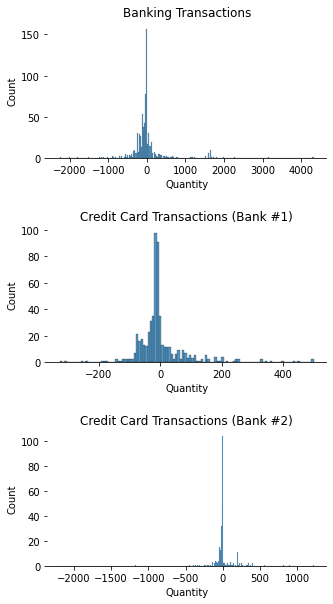

In [16]:
fig, axes = plt.subplots(3, 1, figsize=(5, 10))
fig.subplots_adjust(hspace=0.5) 

sns.despine(left=True)

sns.histplot(df_banking["Quantity"], ax=axes[0])
sns.histplot(df_creditcard_bank01["Quantity"], ax=axes[1])
sns.histplot(df_creditcard_bank02["Quantity"], ax=axes[2])

axes[0].set_title('Banking Transactions')
axes[1].set_title('Credit Card Transactions (Bank #1)')
axes[2].set_title('Credit Card Transactions (Bank #2)') 

### Transactions in time

[Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Quantity (CAD)'),
 Text(0.5, 1.0, 'Credit card transactions from bank 2')]

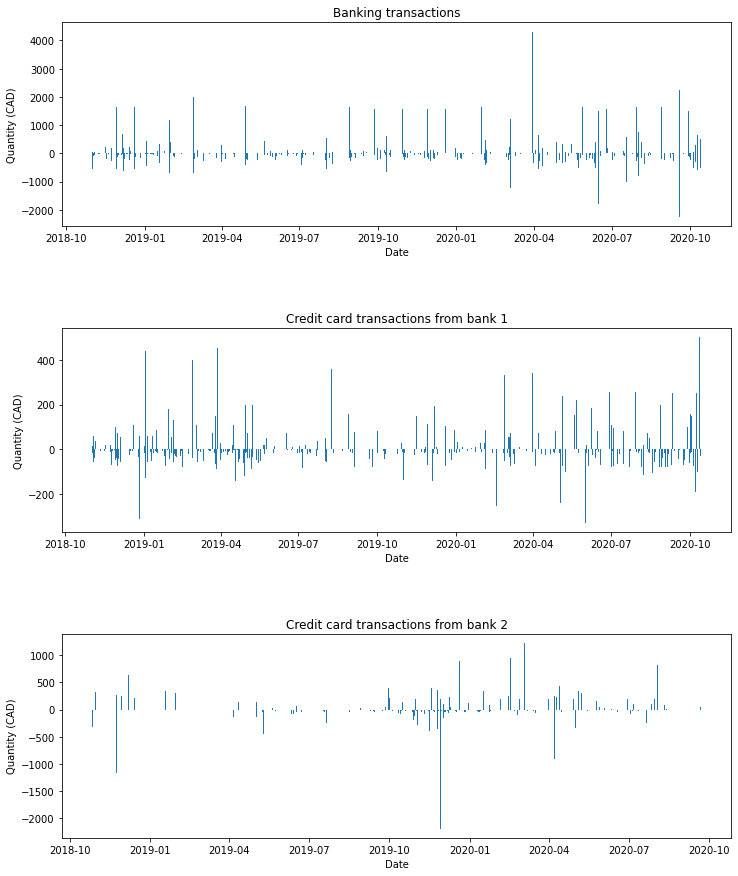

In [17]:
# Create figure and plot space
fig, axes = plt.subplots(3, 1, figsize=(12, 15))
fig.subplots_adjust(hspace=0.5)

# For banking
axes[0].bar(df_banking.index.values, df_banking['Quantity'])
axes[1].bar(df_creditcard_bank01.index.values, df_creditcard_bank01['Quantity'])
axes[2].bar(df_creditcard_bank02.index.values, df_creditcard_bank02['Quantity']) 

# Set title and labels for axes
axes[0].set(xlabel="Date", ylabel="Quantity (CAD)", title="Banking transactions")
axes[1].set(xlabel="Date", ylabel="Quantity (CAD)", title="Credit card transactions from bank 1")
axes[2].set(xlabel="Date", ylabel="Quantity (CAD)", title="Credit card transactions from bank 2")



### Transactions by week and weekday
I am interested to see if the month, the day of the week, the day of month or the week of the year will make a difference

Text(0.5, 1.0, 'Credit Card Transactions (Bank #2)')

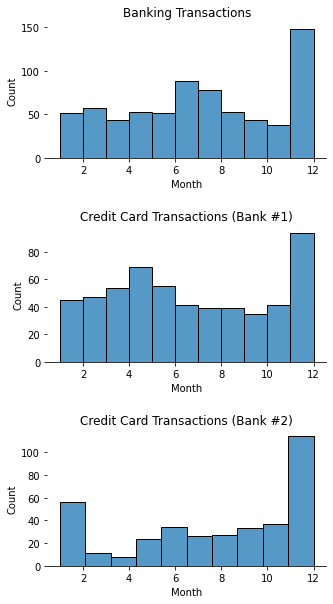

In [18]:
fig, axes = plt.subplots(3, 1, figsize=(5, 10))
fig.subplots_adjust(hspace=0.5) 

sns.despine(left=True)

sns.histplot(df_banking["Month"], ax=axes[0])
sns.histplot(df_creditcard_bank01["Month"], ax=axes[1])
sns.histplot(df_creditcard_bank02["Month"], ax=axes[2])

axes[0].set_title('Banking Transactions')
axes[1].set_title('Credit Card Transactions (Bank #1)')
axes[2].set_title('Credit Card Transactions (Bank #2)') 

Text(0.5, 1.0, 'Credit Card Transactions (Bank #2)')

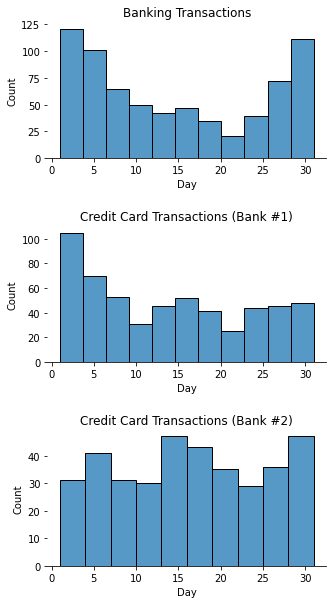

In [19]:
fig, axes = plt.subplots(3, 1, figsize=(5, 10))
fig.subplots_adjust(hspace=0.5) 

sns.despine(left=True)

sns.histplot(df_banking["Day"], ax=axes[0])
sns.histplot(df_creditcard_bank01["Day"], ax=axes[1])
sns.histplot(df_creditcard_bank02["Day"], ax=axes[2])

axes[0].set_title('Banking Transactions')
axes[1].set_title('Credit Card Transactions (Bank #1)')
axes[2].set_title('Credit Card Transactions (Bank #2)') 

Text(0.5, 1.0, 'Credit Card Transactions (Bank #2)')

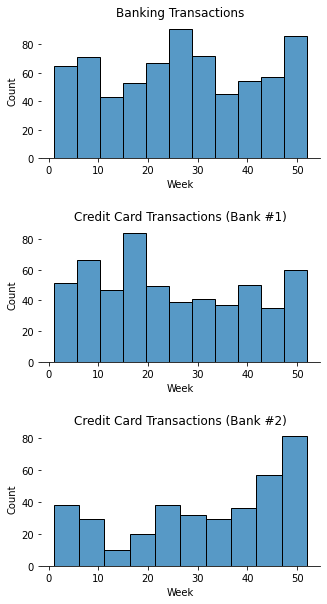

In [20]:
fig, axes = plt.subplots(3, 1, figsize=(5, 10))
fig.subplots_adjust(hspace=0.5) 

sns.despine(left=True)

sns.histplot(df_banking["Week"], ax=axes[0])
sns.histplot(df_creditcard_bank01["Week"], ax=axes[1])
sns.histplot(df_creditcard_bank02["Week"], ax=axes[2])

axes[0].set_title('Banking Transactions')
axes[1].set_title('Credit Card Transactions (Bank #1)')
axes[2].set_title('Credit Card Transactions (Bank #2)') 

Text(0.5, 1.0, 'Credit Card Transactions (Bank #2)')

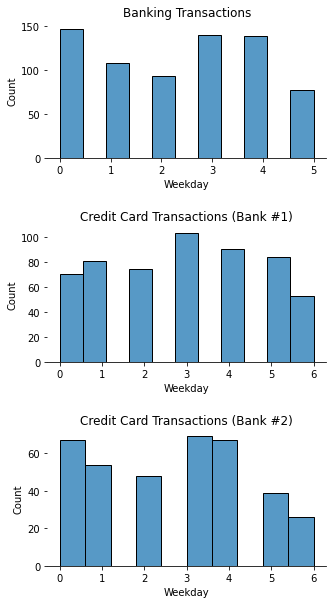

In [21]:
fig, axes = plt.subplots(3, 1, figsize=(5, 10))
fig.subplots_adjust(hspace=0.5) 

sns.despine(left=True)

sns.histplot(df_banking["Weekday"], ax=axes[0])
sns.histplot(df_creditcard_bank01["Weekday"], ax=axes[1])
sns.histplot(df_creditcard_bank02["Weekday"], ax=axes[2])

axes[0].set_title('Banking Transactions')
axes[1].set_title('Credit Card Transactions (Bank #1)')
axes[2].set_title('Credit Card Transactions (Bank #2)') 

### Conclusion
- The months where I made more transactions were January and December. A peak in June/July can also be observed. This

## Categorizing transactions


### Selection of transactions of interest
Data is available from different dates according to the financial product. The selected dates are from Dec 1, 2018 to Sep 30, 2020

In [22]:
date01 = datetime.date(2018, 12, 1)
date02 = datetime.date(2020, 9, 30)
df_banking = df_banking[(df_banking.index.date >= date01) & (df_banking.index.date <= date02)]
df_creditcard_bank01 = df_creditcard_bank01[(df_creditcard_bank01.index.date >= date01) & (df_creditcard_bank01.index.date <= date02)]
df_creditcard_bank02 = df_creditcard_bank02[(df_creditcard_bank02.index.date >= date01) & (df_creditcard_bank02.index.date <= date02)]


### Quick view on description fields
A quick look on the description field show us that we can use it to help the clasification of transactions. It is interesting that Bank 2 provides a category field. For this first part of the process, that column won't be used. The idea is to compare the classification of the transactions with the one provided by the bank.

In [23]:
df_banking['Transaction description'].unique()[:10]

array(['Bill Payment           ', 'POS Purchase           ',
       'DEPOSIT                ', 'ABM Withdrawal',
       'Miscellaneous Payment  ', 'Customer Transfer Dr.  ',
       'Customer Transfer Cr.  ', 'Payroll Deposit        ',
       'WITHDRAWAL             ', 'Service Charge         '], dtype=object)

In [24]:
df_banking['Transaction Type'].unique()[:10]

array(['MB-SCOTIA SCENE VISA CARD', 'FPOS TIM HORTONS #0604# QSTRAT',
       'FPOS THE BOOK STORE AT WELONDO', 'GPOS CENTRE SPOT         LONDO',
       'GPOS ENGINEERING         LONDO', 'MB-EMAIL MONEY TRF', 'NA',
       'MB-CAPITAL ONE MASTERCARD', 'PAYPAL                       ',
       'FPOS ENGINEERING         LONDO'], dtype=object)

In [25]:
df_creditcard_bank01['Transaction description'].unique()[:10]

array(['MB-CREDIT CARD/LOC PAY.           FROM - 553760500321 ',
       'LATINO MARKET HERMIDA INCLONDON       ON  (GOOGLE PAY) ',
       'SHOPPERS DRUG MART0765   LONDON       ON  (GOOGLE PAY) ',
       'DOLLARAMA # 336          LONDON       ON  (GOOGLE PAY) ',
       'UberBV                   Amsterdam    ON ',
       'STAPLES STORE #9         LONDON       ON  (GOOGLE PAY) ',
       'FARM BOY #93             LONDON       ON  (GOOGLE PAY) ',
       'Amazon web services      aws.amazon.coWA AMT            28.20 UNITED STATES DOLLAR ',
       "ANGELO'S ITALIAN MARKE   LONDON       ON ",
       'ADOBE *PHOTOGPHY PLAN    8008336687   CA AMT            11.29 UNITED STATES DOLLAR '],
      dtype=object)

In [26]:
df_creditcard_bank02['Description'].unique()[:10]

array(['PAYMENT', 'INTEREST CHARGE ADJUSTMENT', 'INTEREST CHARGES',
       'COSTCO WHOLESALE W530', 'EXITO SANTA MARTA CENT',
       'PTO DE FABRICA BUCARAM', 'LA CASONA RESTAURANTE',
       'PLAYA DEL RITMO', 'JUAN VALDEZ RECINTO DE', 'SUBWAY 17206'],
      dtype=object)

In [27]:
df_creditcard_bank02['Category'].unique()[:10]

array(['Payment/Credit', 'Fee/Interest Charge', 'Merchandise', 'Dining',
       'Lodging', 'Health Care', 'Gas/Automotive', 'Other',
       'Other Services', 'Entertainment'], dtype=object)

In [28]:
df_banking[['Transaction description', 'Transaction Type', 'Year', 'Quantity']].groupby(['Transaction description', 'Transaction Type', 'Year']).sum().head()

Quantity
Transaction description Transaction Type              Year          
ABM Deposit             NA                            2019   1166.80
ABM Withdrawal          NA                            2018   -240.00
                                                      2019   -686.45
                                                      2020    -62.00
Accounts Payable        UNIVERSITY OF WESTERN ONTARIO 2019    961.57

In [29]:
df_creditcard_bank01[['Transaction description', 'Year', 'Quantity']].groupby(['Transaction description', 'Year']).sum().head()

Quantity
Transaction description                            Year          
168 SUSHI ASIAN BUFFET   LONDON       ON           2019    -79.47
64053 MACS CONV. STORES  MOUNT BRYDGESON           2020   -120.66
A&W #4614                LISTOWEL     ON           2019    -27.75
ADOBE *PHOTOGPHY PLAN    8008336687   CA AMT   ... 2018    -15.44
                                                   2019   -154.69

In [30]:
df_creditcard_bank02[['Description', 'Year', 'Quantity']].groupby(['Description', 'Year']).sum().head()

,,Quantity
Description,Year,
#293 SPORT CHEK,2019,-6.53
01013 MACS CONV. STORE,2019,-5.40
168 SUSHI ASIAN BUFFET,2019,-84.47
64053 MAC'S CONVENIE,2019,-41.89
64053 MACS CONV. STORE,2019,-267.74


### Joining the data
I will join the three data sets. A new column corresponding to the original dataset will be created


In [31]:
df_banking['Original DF'] = 'Banking'
df_creditcard_bank01['Original DF'] = 'Credit Card - Bank 1'
df_creditcard_bank02['Original DF'] = 'Credit Card - Bank 2'

In [32]:
df_transactions_01a = df_banking.copy()
df_transactions_01a = df_transactions_01a.drop(columns=['Transaction Type'])
df_transactions_01a = df_transactions_01a.reset_index()

df_transactions_01b = df_creditcard_bank01.copy()
df_transactions_01b = df_transactions_01b.reset_index()

df_transactions_01c = df_creditcard_bank02.copy()
df_transactions_01c = df_transactions_01c.drop(columns=['Category', 'Debit', 'Credit'])
df_transactions_01c = df_transactions_01c.rename(columns={'Description': 'Transaction description'})
df_transactions_01c = df_transactions_01c.reset_index()

df_transactions_01b

,Transaction Date,Transaction description,Quantity,Year,Month,Day,Week,Weekday,Original DF
0,2018-12-01,MB-CREDIT CARD/LOC PAY. FROM - 55376...,72.50,2018,12,1,48,5,Credit Card - Bank 1
1,2018-12-01,MB-CREDIT CARD/LOC PAY. FROM - 55376...,68.00,2018,12,1,48,5,Credit Card - Bank 1
2,2018-12-01,MB-CREDIT CARD/LOC PAY. FROM - 55376...,12.78,2018,12,1,48,5,Credit Card - Bank 1
3,2018-12-01,LATINO MARKET HERMIDA INCLONDON ON (GOO...,-72.50,2018,12,1,48,5,Credit Card - Bank 1
4,2018-12-01,SHOPPERS DRUG MART0765 LONDON ON (GOO...,-32.77,2018,12,1,48,5,Credit Card - Bank 1
...,...,...,...,...,...,...,...,...,...
504,2020-09-27,WINNERS 441 COLLINGWOOD ON,-42.91,2020,9,27,39,6,Credit Card - Bank 1
505,2020-09-27,STAPLES/BUSINESS DEPOT COLLINGWOOD ON,-37.02,2020,9,27,39,6,Credit Card - Bank 1
506,2020-09-28,DOLLARAMA #1222 KOMOKA ON,-30.31,2020,9,28,40,0,Credit Card - Bank 1
507,2020-09-28,JOLLEY`S DAIRY BAR &VIDEOFLESHERTON ON,-3.75,2020,9,28,40,0,Credit Card - Bank 1


In [33]:
frames = [df_transactions_01a, df_transactions_01b, df_transactions_01c]
df_transactions = pd.concat(frames)
df_transactions = df_transactions.reset_index().drop(columns='index').sort_values(['Transaction Date']).reset_index().drop(columns='index')

In [34]:
df_transactions.head()

,Transaction Date,Quantity,Transaction description,Year,Month,Day,Week,Weekday,Original DF
0,2018-12-01,-68.00,Bill Payment,2018,12,1,48,5,Banking
1,2018-12-01,12.78,MB-CREDIT CARD/LOC PAY. FROM - 55376...,2018,12,1,48,5,Credit Card - Bank 1
2,2018-12-01,-72.50,LATINO MARKET HERMIDA INCLONDON ON (GOO...,2018,12,1,48,5,Credit Card - Bank 1
3,2018-12-01,-32.77,SHOPPERS DRUG MART0765 LONDON ON (GOO...,2018,12,1,48,5,Credit Card - Bank 1
4,2018-12-01,-22.94,DOLLARAMA # 336 LONDON ON (GOO...,2018,12,1,48,5,Credit Card - Bank 1


## Text Analysis for Transaction description field
### Pre-processing
Within the transaction description, we can see items with numbers, for example for transactions related with Dollarama have associated a number corresponding to the store. However, for this analysis what I want to know is the category of the expense and not the place. In that sense, the 'Transaction description' is converted to lower case and the numbers and symbols are eliminated.

* Example for "Dollarama"

In [35]:
df_transactions[df_transactions['Transaction description'].str.contains('DOLLARAMA')].head()

,Transaction Date,Quantity,Transaction description,Year,Month,Day,Week,Weekday,Original DF
4,2018-12-01,-22.94,DOLLARAMA # 336 LONDON ON (GOO...,2018,12,1,48,5,Credit Card - Bank 1
113,2019-01-17,-15.59,DOLLARAMA # 485 LONDON ON (GOO...,2019,1,17,3,3,Credit Card - Bank 1
164,2019-02-17,-9.66,DOLLARAMA # 291 STRATHROY ON,2019,2,17,7,6,Credit Card - Bank 1
204,2019-03-16,-24.01,DOLLARAMA #1222 KOMOKA ON,2019,3,16,11,5,Credit Card - Bank 1
258,2019-04-06,-14.69,DOLLARAMA #1075 LONDON ON,2019,4,6,14,5,Credit Card - Bank 1


*Noise Cleaning*
* Making the transaction description lower case
* Erasing the special characters

In [39]:
df_transactions['Transaction description'] = df_transactions['Transaction description'].str.lower()
df_transactions['Transaction description'] = df_transactions['Transaction description'].apply(lambda x: re.sub(r'[^a-zA-Z\s\']+', '', x))

In [40]:
df_transactions[df_transactions['Transaction description'].str.contains('dollarama')].head()

,Transaction Date,Quantity,Transaction description,Year,Month,Day,Week,Weekday,Original DF
4,2018-12-01,-22.94,dollarama london on google pay,2018,12,1,48,5,Credit Card - Bank 1
113,2019-01-17,-15.59,dollarama london on google pay,2019,1,17,3,3,Credit Card - Bank 1
164,2019-02-17,-9.66,dollarama strathroy on,2019,2,17,7,6,Credit Card - Bank 1
204,2019-03-16,-24.01,dollarama komoka on,2019,3,16,11,5,Credit Card - Bank 1
258,2019-04-06,-14.69,dollarama london on,2019,4,6,14,5,Credit Card - Bank 1


* Counting the words

- The 10 most used words are:


<AxesSubplot:xlabel='Count'>

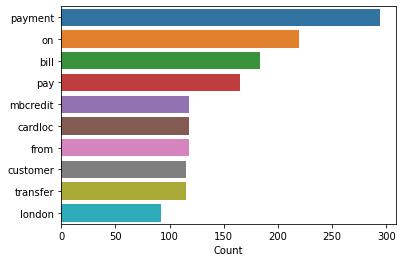

In [41]:
word_count = df_transactions['Transaction description'].str.split(expand=True).stack().value_counts()
word_count = pd.DataFrame(data=word_count, columns=['Count'])
word_count = word_count.sort_values(['Count'], ascending=False)
print('- The 10 most used words are:')

most_used = word_count[:10]

sns.barplot(x=most_used['Count'], y=most_used.index)


### Calculating tf-idf scores
To classify the transactions, I will use a tf-idf score on the transaction description. The idea is to have a metric that help with the clasiffication. Tf-idf means term-frequency times inverse document-frequency.  tf-idf is the combination of two metrics:
* Term frequency
* Inverse document frequency

Refer sklearn documentation for tf-idf and count vectorizer [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)

In [46]:
transformer = TfidfTransformer(smooth_idf=False)
count_vectorizer = CountVectorizer(ngram_range=(1, 2))

In [50]:
# fit transaction data to the count vectorizer
transaction_counts = count_vectorizer.fit_transform(df_transactions['Transaction description'].values)

#fit the ngrams count to the tfidf transformers
transaction_tfidf = transformer.fit_transform(transaction_counts)

In [55]:

transaction_tfidf?